## Import

In [134]:
import geopandas as gpd
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
import rioxarray
from scipy.sparse import csr_matrix
from shapely.geometry import Point
import xrspatial

from pycda.grid_utils import ids_from_shape
from pycda.grid_utils import id_to_rowcol
from pycda.cost_distance import CostDistance

## Load Data

In [135]:
dem = rioxarray.open_rasterio("../data/subbasin.tif", masked=True).squeeze()
stream_raster = rioxarray.open_rasterio("../data/flowpaths.tif", masked=True).squeeze()
stream_raster = stream_raster.rio.reproject_match(dem)
stream_raster.data[np.isnan(dem.data)] = np.nan

start_point = Point(-219663.000, 35749.000)
end_point = Point(-217000.000, 34000.000)

## Create Graph using numba

In [136]:
def dem_to_graph(dem, walls, enforce_uphill=False, enforce_downhill=False):
    data, ids = _create_graph_data_numba(dem, walls, enforce_uphill, enforce_downhill)
    graph = csr_matrix(data, shape=(ids.size, ids.size))
    return graph

@njit
def _create_graph_data_numba(dem, walls, enforce_uphill, enforce_downhill):
    nrows, ncols = dem.shape
    ids = np.arange(dem.size).reshape(dem.shape)
    row_inds = []
    col_inds = []
    data = []
    for row in range(nrows):
        for col in range(ncols):
            start  = ids[row,col]

            if walls is not None:
                if walls[row, col]:
                    continue

            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    if dx == 0 and dy == 0:
                        continue
                    nx = row + dx
                    ny = col + dy
                    end = ids[nx,ny]

                    if walls is not None:
                        if walls[nx, ny]:
                            continue

                    if 0 <= nx < nrows and 0 <= ny < ncols:
                        cost = 1 if dx == 0 or dy == 0 else 1.41
                        cost *= dem[nx, ny] - dem[row, col]

                        if cost < 0 and enforce_uphill:
                            continue

                        if cost > 0 and enforce_downhill:
                            continue

                        data.append(np.abs(cost))
                        row_inds.append(start)
                        col_inds.append(end)

    return (data, (row_inds, col_inds)), ids

In [137]:
graph = dem_to_graph(dem.data, walls=np.isnan(dem.data))

In [138]:
cost_distance = CostDistance(dem, graph, method='directional')

## Least Cost Path

In [139]:
path = cost_distance.trace_path(end_point, start_point, return_type='vector')

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

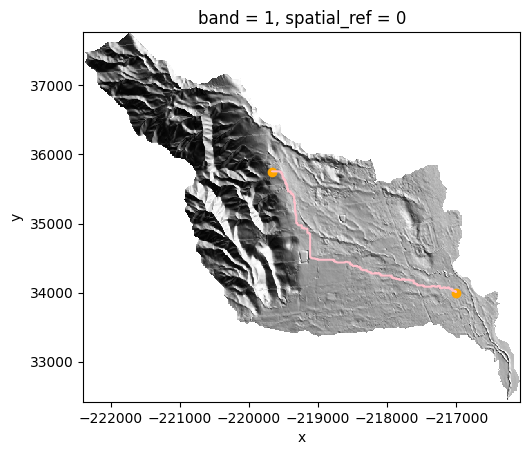

In [140]:
fig, ax = plt.subplots()
hillshade = xrspatial.hillshade(dem)
hillshade.plot(ax=ax, cmap='gray', add_colorbar=False)
gpd.GeoSeries([start_point, end_point], crs=3310).plot(ax=ax, color='orange')
gpd.GeoSeries(path, crs=3310).plot(ax=ax, color='pink')

## Cost Accumulation

In [141]:
costs, basins = cost_distance.cost_accumulation(sources = (stream_raster > 0), return_basins=True)

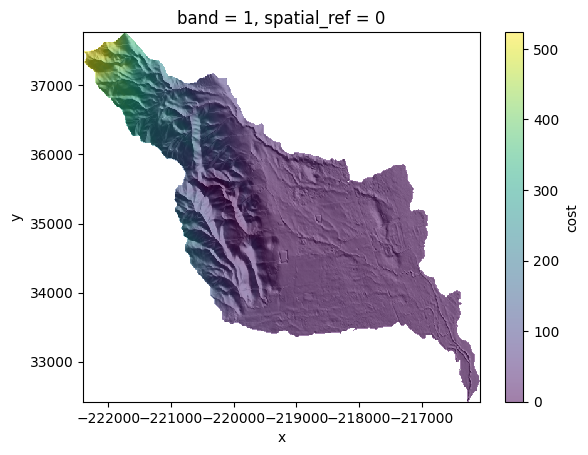

In [142]:
fig, ax = plt.subplots()
hillshade.plot(ax=ax, cmap='gray', add_colorbar=False)
costs.clip(min=0).plot(ax=ax, alpha=0.5)

## HAND

In [143]:
conditioned = rioxarray.open_rasterio("../data/subbasin_conditioned.tif", masked=True).squeeze()
streams = stream_raster.rio.reproject_match(conditioned)
graph = dem_to_graph(conditioned.data, walls=np.isnan(conditioned.data), enforce_uphill=True)
cost_distance = CostDistance(conditioned, graph, method='directional')

In [144]:
costs, basins = cost_distance.cost_accumulation(sources = (streams > 0), return_basins=True)

In [145]:
# given basins raster -> get associated elevation raster -> subtract from original DEM to get HAND
row_inds, col_inds = np.meshgrid(np.arange(conditioned.shape[0]), np.arange(conditioned.shape[1]), indexing="ij")
basin_cell_elevation = conditioned.copy()
row_inds = row_inds.flatten()
col_inds = col_inds.flatten()

In [146]:
for i,basin_id in enumerate(np.unique(basins)):       
    if basin_id < 0:
        value = np.nan
    else:
        r = row_inds[basin_id]
        c = col_inds[basin_id]
        value = conditioned[r,c]

    basin_cell_elevation.data[basins == basin_id] = value

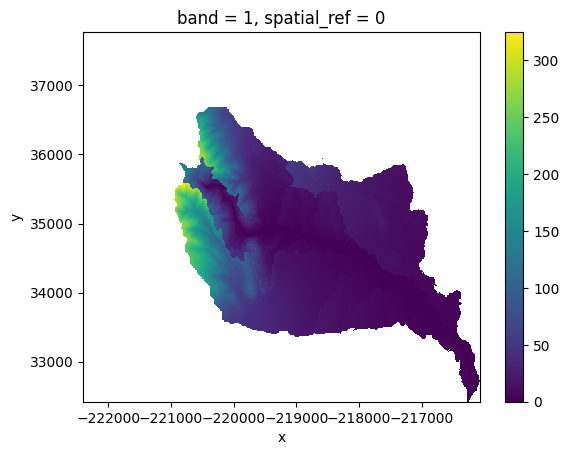

In [147]:
HAND = (conditioned - basin_cell_elevation)
HAND.clip(min=0).plot()

# note this is effectively very similar to the cost (sum of elevation change going downhill) differs due to cost associated with diagonal traversal (1.41 * delta_elevation). 